In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import os
import glob
import json
import geopandas as gp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from scipy import stats



# Data

In [2]:
data_path = '../../data/'
start_wave1 = '2020-03-01'
end_wave1 = '2020-06-04'

In [3]:
NIS_name = pd.read_csv(data_path+'raw/GIS/NIS_name.csv')
NIS_arrondissement = pd.read_csv(data_path+'raw/GIS/NIS_arrondissement.csv')
inhabitants = pd.read_csv(data_path+'raw/GIS/inhabitants.csv')
inhabitants.NIS = inhabitants.NIS.astype(str)


In [4]:
# Read arrondissements shapefile
arrondissementen = gp.read_file(data_path+"raw/GIS/shapefiles/BE/Arrondissements.shp")
provinces = gp.read_file(data_path+"raw/GIS/shapefiles/BE/AD_4_Province.shp")
arrondissementen['area'] = arrondissementen.geometry.area

In [5]:
arr_age_structure = pd.read_csv(data_path+'interim/demographic/age_structure_per_arrondissement.csv')
arr_age_structure.NIS = arr_age_structure.NIS.astype(str)

age_over_60 = arr_age_structure.groupby('NIS').apply(
    lambda x: x.loc[x.age>60, 'number'].sum()/x.number.sum()).reset_index().rename(columns={0:'age_over_60'})

# median: number.sum()/2
# x[x.number.cumsum().gt(x.number.sum()/2)].index[0] = position of first cumsum number larger than
median_age = arr_age_structure.groupby('NIS').apply(
    lambda x: x.loc[x[x.number.cumsum()>x.number.sum()/2].index[0], 'age']).reset_index().rename(columns={0:'median_age'})

https://statbel.fgov.be/nl/open-data/census-2011-leeftijd-arbeidsmarktsituatie-opleidingsniveau-verblijfplaats-0

In [ ]:
socio_economic = pd.read_csv(data_path+'raw/census_2011/socio_economic.txt', delimiter='|')

In [ ]:
socio_economic

# Timeseries

In [6]:
nonpublic_ts = pd.read_csv(data_path+'/interim/non_public/all_nonpublic_timeseries.csv', parse_dates=['DATE'])
nonpublic_ts.NIS = nonpublic_ts.NIS.astype(str)

In [7]:
hospitalised =  nonpublic_ts.groupby('NIS').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].hospitalised_IN.agg([sum, max])).rename(
                      columns={'sum':'hosp_sum','max':'hosp_max'})

confirmed =  nonpublic_ts.groupby('NIS').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].confirmed_cases.agg([sum, max])).rename(
                      columns={'sum':'conf_sum','max':'conf_max'})

deceased_hosp =  nonpublic_ts.groupby('NIS').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].deceased_hosp.agg([sum, max])).rename(
                      columns={'sum':'deceased_sum','max':'deceased_max'})

In [8]:
data_cols = ['deceased_sum', 'deceased_max', 'conf_sum', 'conf_max','hosp_sum', 'hosp_max']
COVID_data = pd.merge(hospitalised, inhabitants[['NIS','inhabitants']], on='NIS')
COVID_data = pd.merge(confirmed, COVID_data, on='NIS')
COVID_data = pd.merge(deceased_hosp, COVID_data, on='NIS')
COVID_per_100k = COVID_data.copy()
COVID_per_100k[data_cols] = COVID_per_100k[data_cols]/COVID_per_100k[['inhabitants']].values*100000

# Model parameters

In [9]:
samples_path = data_path+'/interim/model_parameters/arrondissements/'
sample_dicts = {}
for filename in glob.glob(os.path.join(samples_path+'*.json')):
    arr = filename.split('/')[-1].split('_2020')[0]
    with open(filename, 'r') as fp:
        sample_dicts[arr] = json.load(fp)

In [20]:
R0_dict = {arr:np.mean(sample_dicts[arr]['R0']) for arr in sample_dicts.keys()}
R0_df = pd.DataFrame.from_dict(R0_dict, orient='index').reset_index().rename(columns={'index':'NIS',0:'R0'})
beta_dict = {arr:np.mean(sample_dicts[arr]['beta']) for arr in sample_dicts.keys()}
beta_df = pd.DataFrame.from_dict(beta_dict, orient='index').reset_index().rename(columns={'index':'NIS',0:'beta'})


Calculation of $R_0$:

\begin{equation}
    R_{0,i} = (a_i d_a + \omega) \beta s_i \sum_{j=1}^{N} N_{c,ij}
\end{equation}

with:   
$a_i$: probablity of an asymptotic case in age class i   
$d_a$: duration of the infection in case of asymptomatic   
$\omega$: length of the pre-symptomatic infectious period   
$\beta$: probability of infection when encountering an infected person   
$s_i$: relative susceptibility to infection in age class i   
$N_{c,ij}$: contact matrix between age class i and j

Note that only $\beta$ is different among arrondissements, hence $R_0$ and $\beta$ are perfectly correlated.

# Merge all data

In [21]:
arrondissementen_ext = pd.merge(arrondissementen, COVID_per_100k, on='NIS')
arrondissementen_ext = pd.merge(arrondissementen_ext, median_age, on='NIS')
arrondissementen_ext = pd.merge(arrondissementen_ext, age_over_60, on='NIS')
arrondissementen_ext = gp.GeoDataFrame(pd.merge(arrondissementen_ext, R0_df, on='NIS'))
arrondissementen_ext = gp.GeoDataFrame(pd.merge(arrondissementen_ext, beta_df, on='NIS'))
arrondissementen_ext['density_per_km2'] = arrondissementen_ext.inhabitants/arrondissementen_ext.area*1e6
# Omit outlier Brussels capital region (also in relative terms!)
arrondissementen_ext = arrondissementen_ext[arrondissementen_ext.density_per_km2<6000]

# Linear correlation figures

In [22]:
def fig_lin_corr(ax,x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(arrondissementen_ext[x],arrondissementen_ext[y])
    pd.DataFrame(arrondissementen_ext).plot(x, y, kind='scatter', ax=ax)
    ax.set_title(y+' vs '+x+': \n R$^2$ = {:.2f}, p = {:.3f}'.format(r_value**2, p_value))
    return

## Relations with population density

More meaningful to take absolute values of max/total COVID cases, or per 100000?

In [15]:
1209e6/161.4

7490706.319702602

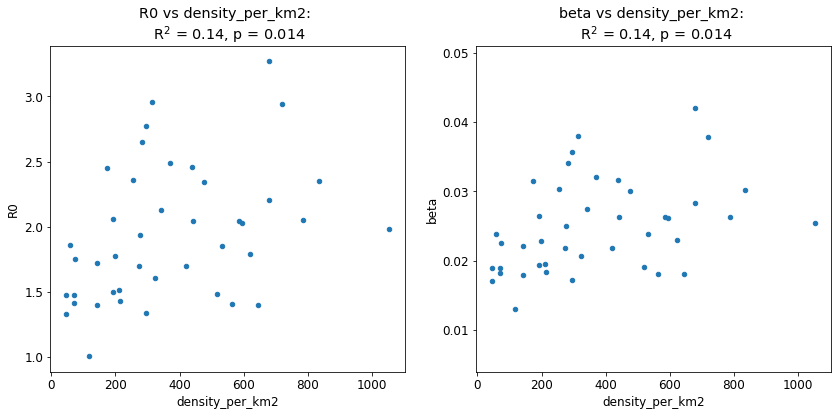

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, 'density_per_km2','R0')
fig_lin_corr(ax2, 'density_per_km2','beta')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1,'density_per_km2','hosp_sum')
fig_lin_corr(ax2,'density_per_km2','hosp_max')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1,'density_per_km2','conf_sum')
fig_lin_corr(ax2,'density_per_km2','conf_max')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1,'density_per_km2','deceased_sum')
fig_lin_corr(ax2,'density_per_km2','deceased_max')


## Relations with demographics

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, 'median_age','R0')
fig_lin_corr(ax2, 'median_age','beta')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, 'age_over_60','R0')
fig_lin_corr(ax2, 'age_over_60','beta')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1,'age_over_60','deceased_sum')
fig_lin_corr(ax2,'age_over_60','deceased_max')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1,'age_over_60','hosp_sum')
fig_lin_corr(ax2,'age_over_60','hosp_max')


# Maps

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
arrondissementen_ext.plot(column='R0', cmap='viridis', ax=ax, legend=True)
ax.set_title('R0 per arrondissement')

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
arrondissementen_ext.plot(column='beta', cmap='viridis', ax=ax, legend=True)
ax.set_title('beta per arrondissement')

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
provinces.plot(ax=ax)